# Apply Random Forest

In [1]:
library(grid)
library(rpart)
library(rpart.plot)
library(partykit)
library(lattice)
library(ggplot2)
library(caret)
library(e1071)
library(randomForest)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin



In [2]:
set.seed(1)

In [3]:
invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'flag', 'Curve100', 'Curve150', 'TimeHeadway')
# invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'flag', 'Curve100', 'Curve150')

In [4]:
valuables <- c("RoadType","CurveAverage","Speed","MaxSpeed","RiskFactor","Curve","DistSignal","Pitch","AheadDistance","AverageVelocity","TimeToCollision","AccelerationSpeed","LaneCount","Engine","PathType","SteeringAngle")

In [5]:
printf <- function(...) cat(sprintf(...))

In [29]:
CV <- function(dfx, verbose=FALSE) {        
    folds <- createFolds(dfx$flag)
    
    count <- 1
    errs <- c()
    reds <- c()
    blues <- c()
    for (ids in folds) {
        train <- dfx[-ids, ]
        test <- dfx[ids, ]
        fit <- randomForest(flag ~ ., data=train, mtry=3, ntree=500)
        p <- predict(fit, newdata=test)
        
        if (verbose) {            
            printf("Fold%d\n", count)
            result <- correctVsPredict(test, p)
            reds <- c(reds, result[1])
            blues <- c(blues, result[2])
            count <- count + 1
            printf("\n")
        }
        
        nerr <- sum((p == test$flag) == FALSE)
        errs <- c(errs, nerr / nrow(test))
    }
    
    return(c(mean(errs), mean(reds), mean(blues)))
}

In [30]:
correctVsPredict <- function(test, predictedFlags) {    
    # for All
    # nTests <- nrow(test)
    # nCorrectAll <- sum((predictedFlags == test$flag) == TRUE)
    # printf("As fo All: correct/all = %d/%d = %f\n", nCorrectAll, nTests, nCorrectAll / nTests)
    
    # for Red
    predictedRedRows <- test[predictedFlags == "Red", ]
    nCorrectReds <- sum((predictedRedRows$flag == 'Red') == TRUE)
    nPredictedReds <- nrow(predictedRedRows)
    printf("As for Red: correct/predict = %d/%d = %f\n", nCorrectReds, nPredictedReds, nCorrectReds / nPredictedReds)
    
    # for Blue
    predictedBlueRows <- test[predictedFlags == "Blue", ]
    nCorrectBlues <- sum((predictedBlueRows$flag == 'Blue') == TRUE)
    nPredictedBlues <- nrow(predictedBlueRows)
    printf("As for Blue: correct/predict = %d/%d = %f\n", nCorrectBlues, nPredictedBlues, nCorrectBlues / nPredictedBlues)
    
    c(nCorrectReds/nPredictedReds, nCorrectBlues/nPredictedBlues)
}

In [31]:
printRedRatios <- function(dfx) {
    nRed <- nrow(dfx[dfx$flag == "Red", ])
    nAll <- nrow(dfx)
    printf("Red/All = %d/%d = %f\n", nRed, nAll, nRed/nAll)
    printf("1 - Red/All = %d/%d = %f\n", nAll - nRed, nAll, 1 - nRed/nAll)
}

In [32]:
createFormula <- function(invalids, allFeatures) {
    isValidColumn <- function(x) ! x %in% invalids
    
    features <- Filter(isValidColumn, allFeatures)
    return(paste("flag ~ ", paste(features, collapse=" + ")))
}

# Predict Red

In [33]:
df3 <- read.csv("../data/middle/sp4.csv", stringsAsFactors=FALSE)

In [34]:
df3$flag[df3$flag == "RedA"] <- "Red"
df3$flag[df3$flag == "RedB"] <- "Red"
df3$flag[df3$flag == "BlueA"] <- "Blue"
df3$flag[df3$flag == "BlueB"] <- "Blue"
df3$flag <- as.factor(df3$flag)

In [35]:
fomula <- paste("flag ~ ", paste(valuables, collapse=" + "))

In [44]:
set.seed(1)

In [46]:
result <- CV(df3, verbose=TRUE)
printRedRatios(df3)
printf("Red: Mean correct/predict = %f\n", result[2])
printf("Blue: Mean correct/predict = %f\n", result[3])
printf("CV value: %f", result[1])

Fold1
As for Red: correct/predict = 46/73 = 0.630137
As for Blue: correct/predict = 18/31 = 0.580645

Fold2
As for Red: correct/predict = 49/74 = 0.662162
As for Blue: correct/predict = 20/30 = 0.666667

Fold3
As for Red: correct/predict = 46/68 = 0.676471
As for Blue: correct/predict = 23/36 = 0.638889

Fold4
As for Red: correct/predict = 50/73 = 0.684932
As for Blue: correct/predict = 21/31 = 0.677419

Fold5
As for Red: correct/predict = 47/69 = 0.681159
As for Blue: correct/predict = 23/36 = 0.638889

Fold6
As for Red: correct/predict = 49/73 = 0.671233
As for Blue: correct/predict = 21/32 = 0.656250

Fold7
As for Red: correct/predict = 49/81 = 0.604938
As for Blue: correct/predict = 13/23 = 0.565217

Fold8
As for Red: correct/predict = 46/67 = 0.686567
As for Blue: correct/predict = 24/37 = 0.648649

Fold9
As for Red: correct/predict = 45/64 = 0.703125
As for Blue: correct/predict = 26/40 = 0.650000

Fold10
As for Red: correct/predict = 48/64 = 0.750000
As for Blue: correct/predict

In [17]:
set.seed(1)

In [18]:
ntree.lim <- seq(50, 600, 30)

tune <- tune.randomForest(
        flag ~ .,
        data=dfx,
        ntree=ntree.lim,
        tunecontrol = tune.control(sampling = "cross", cross = 10)
)

In [19]:
summary(tune)


Parameter tuning of ‘randomForest’:

- sampling method: 10-fold cross validation 

- best parameters:
 ntree
   320

- best performance: 0.336804 

- Detailed performance results:
   ntree     error dispersion
1     50 0.3406593 0.03939560
2     80 0.3444872 0.02993262
3    110 0.3483242 0.03272864
4    140 0.3416300 0.03150583
5    170 0.3531227 0.03836783
6    200 0.3454304 0.03123155
7    230 0.3560073 0.03811674
8    260 0.3502473 0.03154322
9    290 0.3493040 0.03783484
10   320 0.3368040 0.03909203
11   350 0.3444597 0.03610354
12   380 0.3396612 0.03242912
13   410 0.3521612 0.03978797
14   440 0.3483333 0.03221164
15   470 0.3569505 0.04306214
16   500 0.3435531 0.02829887
17   530 0.3492766 0.03567300
18   560 0.3377839 0.04019358
19   590 0.3579212 0.04205685


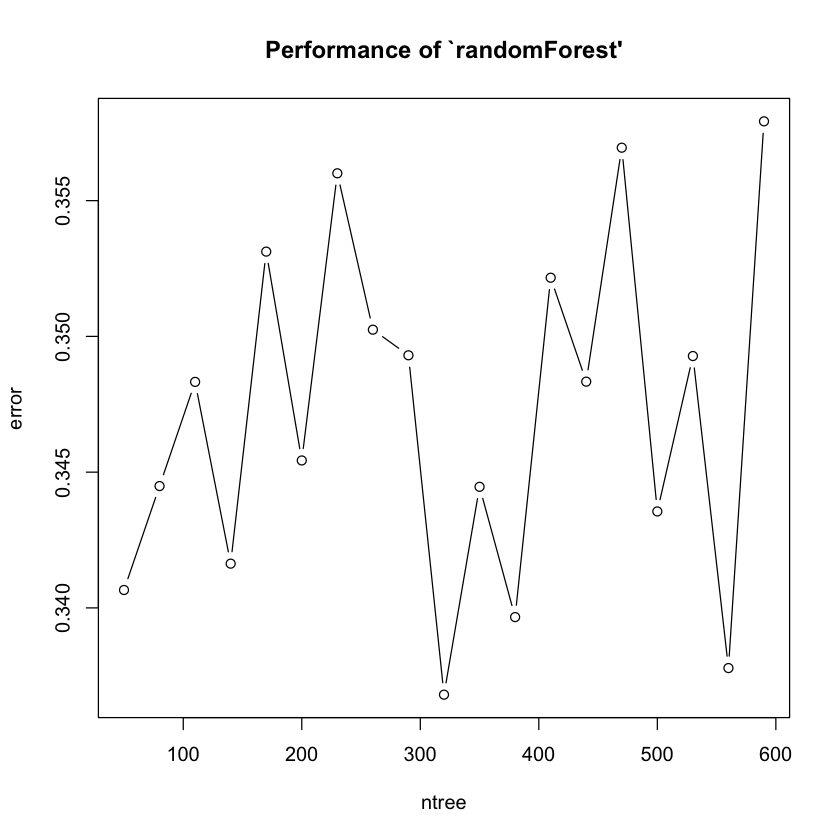

In [20]:
plot(tune)